In [1]:
# Let's keep our notebook clean, so it's a little more readable!
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
# %matplotlib notebook

In [3]:
# Activate only if running from Google Collab
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/
#
# %ls

# Using machine learning to predict age from rs-fMRI

The goal is to extract data from several rs-fmri images, and use that data as features in a machine-learning model. We will integrate what we've learned in the previous machine-learning lecture to build an unbiased model and test it on a left out sample.

![feat_xtrct](https://ars.els-cdn.com/content/image/1-s2.0-S1053811919301594-gr1.jpg)

Link to slides: https://github.com/netneurolab/ipn-summer-school/blob/main/lectures/2021-06-29/13-15/20210629_ipn-summerschool_presentation_IntroML.pdf

# Preparing the data

In [4]:
from nilearn import datasets
from glob import glob
import os

# wdir = '/Users/estefanysuarez/nilearn_data/development_fmri'
data = datasets.fetch_development_fmri(n_subjects=2, reduce_confounds=True, data_dir=None, resume=True, verbose=1, age_group='both')

In order to do our machine learning, we will need to extract features from our rs-fmri images.

Specifically, we will extract signals from a brain parcellation and compute a correlation matrix, representing regional coactivation between regions.

We will practice on one subject first, then we'll extract data for all subjects.

## 1. Retrieve the atlas for extracting features and an example subject

Since we're using rs-fmri data, it makes sense to use an atlas defined using rs-fmri data

This paper has many excellent insights about what kind of atlas to use for an rs-fMRI machine learning task. See in particular Figure 5.

https://www.sciencedirect.com/science/article/pii/S1053811919301594?via%3Dihub

Let's use the MIST atlas, created here in Montreal using the BASC method. This atlas has multiple resolutions, for larger networks or finer-grained ROIs. Let's use a 64-ROI atlas to allow some detail, but to ultimately keep our connectivity matrices manageable.

Here is a link to the MIST paper: https://mniopenresearch.org/articles/1-3

In [5]:
from nilearn import datasets

parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064

print('Atlas ROIs are located in nifti image (4D) at: %s' %
       atlas_filename)

Atlas ROIs are located in nifti image (4D) at: /Users/estefanysuarez/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz


Let's have a look at that atlas

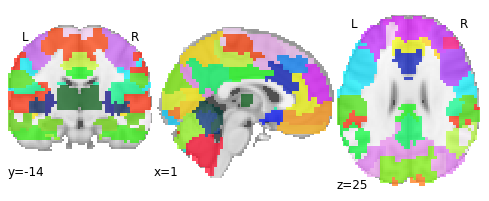

In [6]:
from nilearn import plotting

plotting.plot_roi(atlas_filename, draw_cross=False)

Great, let's load an example 4D fmri time-series for one subject

In [7]:
fmri_filenames = data.func[0]
print(fmri_filenames)

/Users/estefanysuarez/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


Let's have a look at the image! Because it is a 4D image, we can only look at one slice at a time. Or, better yet, let's look at an average image!

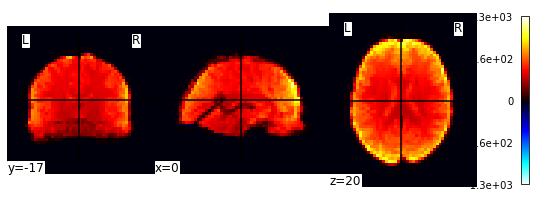

In [8]:
from nilearn import image 

averaged_Img = image.mean_img(image.mean_img(fmri_filenames))
plotting.plot_stat_map(averaged_Img)


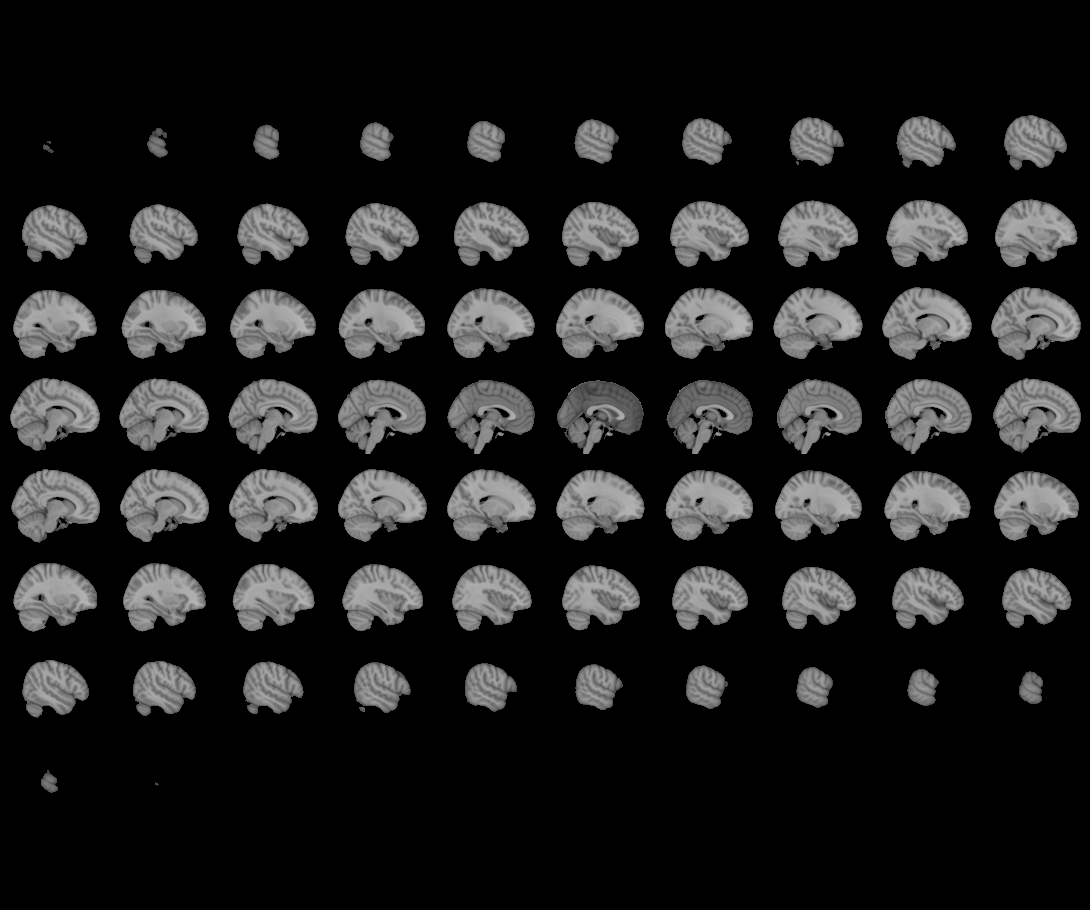
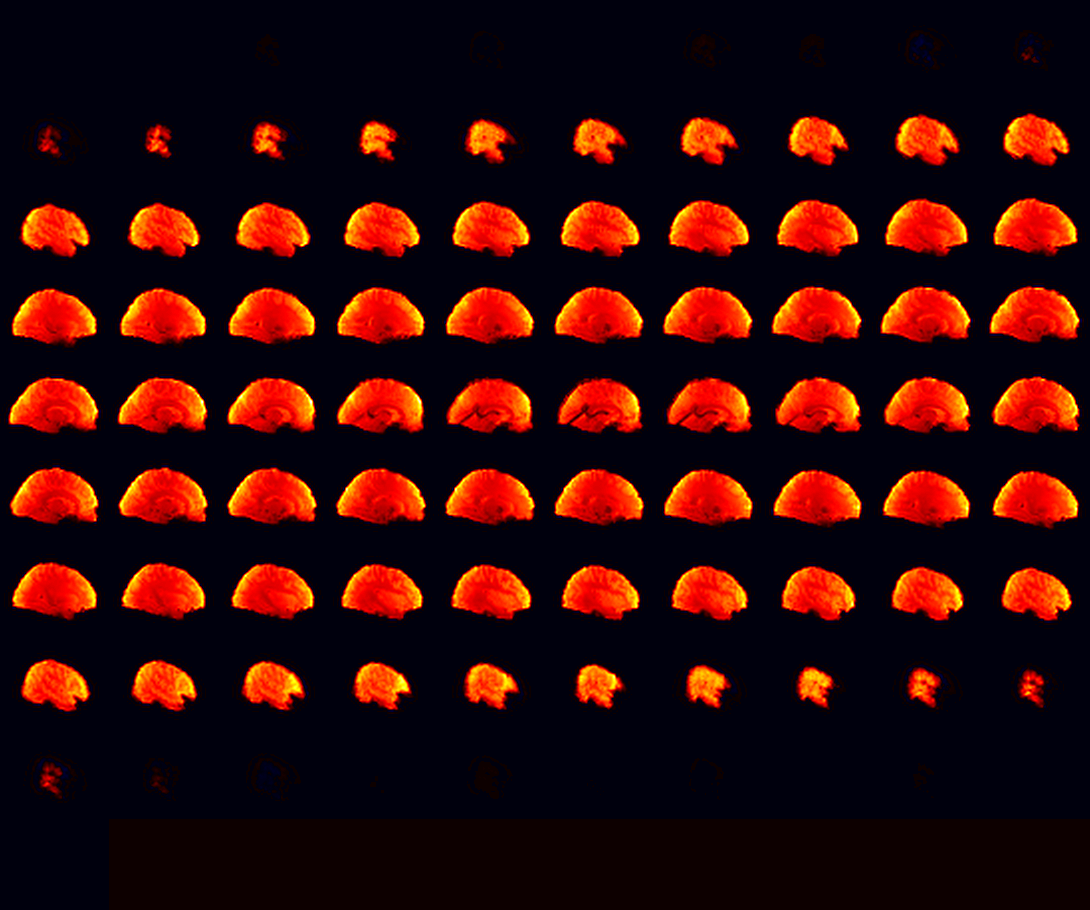

In [9]:
plotting.view_img(averaged_Img)

## 2. Extract signals on a parcellation defined by labels

To do so, we are going to use the NiftiLabelsMasker. 

So we've loaded our atlas and 4D data for a single subject. Let's practice extracting features!

In [10]:
from nilearn.input_data import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=1)

# Here we go from nifti files to the signal time series in a numpy
# array. Note how we give confounds to be regressed out during signal
# extraction
conf = data.confounds[0]
time_series = masker.fit_transform(fmri_filenames, confounds=conf)

[NiftiLabelsMasker.fit_transform] loading data from /Users/estefanysuarez/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
Resampling labels


In [11]:
print(type(time_series))
print(time_series.shape)

<class 'numpy.ndarray'>
(168, 64)


What are these "confounds" and how are they used? 

In [12]:
import pandas
conf_df = pandas.read_table(conf)
conf_df.head()

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,framewise_displacement,a_comp_cor_00,a_comp_cor_01,a_comp_cor_02,a_comp_cor_03,a_comp_cor_04,a_comp_cor_05,csf,white_matter
0,-0.000233,-0.076885,0.062321,0.000732,0.000352,0.000841,0.000000,-0.099871,-0.007286,0.001780,-0.008073,0.030945,-0.022393,439.699409,451.645460
1,-0.006187,-0.078395,0.056773,0.000112,0.000187,0.000775,0.055543,-0.019437,-0.042308,0.016735,-0.012099,0.088777,-0.006171,439.471640,451.103437
2,-0.000227,-0.069893,0.083102,0.000143,0.000364,0.000716,0.054112,0.009096,-0.053206,-0.030388,-0.052925,0.019922,0.014776,439.744498,450.981505
3,0.002492,-0.074707,0.060337,0.000202,0.000818,0.000681,0.057667,0.060195,-0.083195,0.003578,-0.037011,0.026946,0.002505,440.772620,450.600261
4,-0.000226,-0.084204,0.085079,0.000183,0.000548,0.000682,0.051438,0.049833,-0.089819,-0.020825,-0.079329,0.008516,-0.000938,440.115442,450.678959


In [13]:
print(conf_df.shape)

(168, 15)


## 3. Compute and display a correlation matrix

In [14]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
correlation_matrix.shape

(64, 64)

Plot the correlation matrix

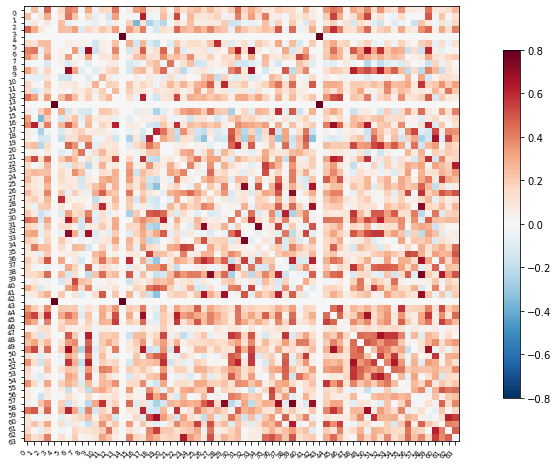

In [15]:
import numpy as np
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

# The labels we have start with the background (0), hence we skip the
# first label
plotting.plot_matrix(correlation_matrix, figure=(10, 8), 
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

# matrices are ordered for block-like representation

## 4. Extract features from the whole dataset

We can now use a for loop to iterate through each 4D image and use the same techniques we learned above to extract rs-fMRI connectivity features from every subject.

# Machine Learning Pipeline

## 1. Load the data

<p align="center">
<img src="Imgs/SampFeat.png" alt="terms" width="300"/>
</p>

### Load input features - X matrix

In [16]:
import numpy as np

feat_file = 'MAIN_BASC064_subsamp_features.npz'
X_features = np.load(feat_file)['a']

n_samples, n_features = X_features.shape
print(f'Our data set contains {n_samples} samples and {n_features} features.')

Our data set contains 155 samples and 2016 features.


Now that we've got our features, we can visualize them as a matrix!

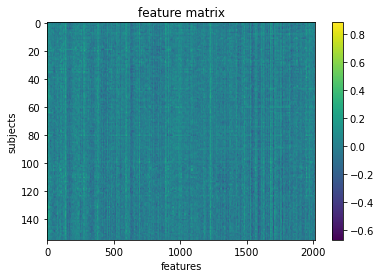

In [17]:
import matplotlib.pyplot as plt

plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')
plt.show()
plt.close()

### Load output labels (our target data) - Y vector

In [18]:
import os
import pandas

# Let's load the phenotype data
pheno_path = os.path.join('participants.tsv')

pheno = pandas.read_csv(pheno_path, sep='\t').sort_values('participant_id')
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness,ToM Booklet-Matched,ToM Booklet-Matched-NOFB,FB_Composite,FB_Group,WPPSI BD raw,WPPSI BD scaled,KBIT_raw,KBIT_standard,DCCS Summary,Scanlog: Scanner,Scanlog: Coil,Scanlog: Voxel slize,Scanlog: Slice Gap
0,sub-pixar001,4.774812,4yo,child,M,R,0.80,0.736842,6.0,pass,22.0,13.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.1
1,sub-pixar002,4.856947,4yo,child,F,R,0.72,0.736842,4.0,inc,18.0,9.0,NaN,NaN,2.0,3T1,7-8yo 32ch,3mm iso,0.1
2,sub-pixar003,4.153320,4yo,child,F,R,0.44,0.421053,3.0,inc,15.0,9.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.1
3,sub-pixar004,4.473648,4yo,child,F,R,0.64,0.736842,2.0,fail,17.0,10.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.2
4,sub-pixar005,4.837782,4yo,child,F,R,0.60,0.578947,4.0,inc,13.0,5.0,NaN,NaN,2.0,3T1,7-8yo 32ch,3mm iso,0.2


Looks like there is a column labeling age. Let's capture it in a variable!

In [19]:
y_age = pheno['Age']

Maybe we should have a look at the distribution of our target variable!

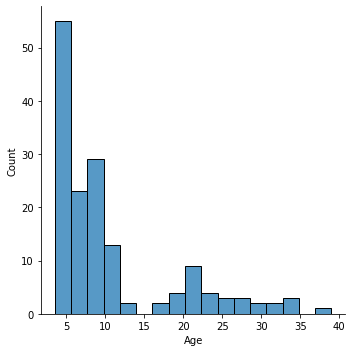

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(y_age)
plt.show()

## 2. Training/test data split

Here, we will divide our data set into *training* and *test* sets. We will use the training set to fit and tweak our model's parameters. The test set will be exclusively used to validate our model, and therefore it will be set aside and **WE WILL NOT TOUCH IT UNTIL THE VERY END!!!**. 

<p align="center">
<img src="Imgs/splitdata.png" alt="terms" width="300"/>
</p>

Now, we want to be sure that our training and test samples are matched! 
We can do that with a "stratified split". This dataset has a variable indicating AgeGroup. We can use that to make sure our training and testing sets are balanced!

In [21]:
age_class = pheno['AgeGroup']
age_class.value_counts()

5yo       34
8-12yo    34
Adult     33
7yo       23
3yo       17
4yo       14
Name: AgeGroup, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split

# Split the sample into training/test sets with a 60/40 ratio, and 
# stratify by age class, and also shuffle the data.

X_train, X_test, y_train, y_test = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.4, # 60%/40% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('Training sample:', len(X_train))
print('Test sample:', len(X_test))

Training sample: 93
Test sample: 62


Let's visualize the distributions to be sure they are matched

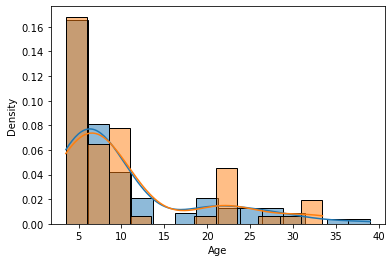

In [23]:
sns.histplot(y_train, label='train', stat='density', kde=True, color=sns.color_palette()[0])
sns.histplot(y_test, label='test', stat='density', kde=True, color=sns.color_palette()[1])
plt.show()
plt.close()

## 3. Train your first ML model!

Machine-learning can get fancy pretty quickly. We'll start with a fairly standard regression model called a **Support Vector Regressor (SVR)**. 

While this may seem unambitious, simple models can be very robust. And we probably don't have enough data to create more complex models (but we can try later).

For more information, see this excellent resource:
https://hal.inria.fr/hal-01824205

Let's fit our first model!

<p align="center">
<img src="Imgs/modfit.png" alt="terms" width="400"/>
</p>

In [24]:
from sklearn.svm import SVR

# define the model
l_svr = SVR(kernel='linear') 

# fit the model
l_svr.fit(X_train, y_train) 

SVR(kernel='linear')

## 4. Validate your model
Well... that was easy. Now let's see how well the model learned the data!

<p align="center">
<img src="Imgs/modval.png" alt="terms" width="800"/>
</p>

But, two questions first:

1. What happens if I validate my model with my **train** set? 
2. What happens if I validate my model with the **test** set?

Let's try with the **training** set:

In [25]:
# predict the training data based on the model
y_pred = l_svr.predict(X_train) 

# caluclate the model accuracy
acc = l_svr.score(X_train, y_train) # the default score for the SVR model is the coefficient of determination R2

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true=y_train,y_pred=y_pred)

Let's view our results and plot them all at once!

Accuracy (R2) =  0.9998486731363846
MAE           =  0.09830411993987148


Text(0.5, 0, 'Predicted Age')

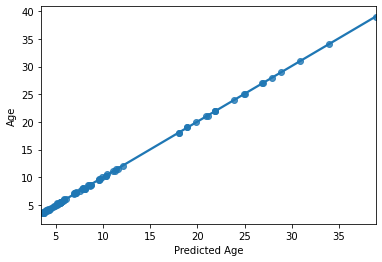

In [26]:
# print results
print('Accuracy (R2) = ', acc) 
print('MAE           = ', mae) 

sns.regplot(y_pred,y_train)
plt.xlabel('Predicted Age')
# plt.show()

HOLY COW! Machine-learning is amazing!!! Almost a perfect fit :O ... which means there's must be something wrong. What's the problem here?

## 5. Cross-Validation (CV)

<p align="center">
<img src="Imgs/CV.png" alt="terms" width="300"/>
</p>

In [27]:
from sklearn.model_selection import train_test_split

# Split the sample into training/validation sets with a 75/25 ratio, and 
# stratify by age class, and also shuffle the data.

age_class2 = pheno.loc[y_train.index,'AgeGroup']

X_train2, X_val, y_train2, y_val = train_test_split(
                                                    X_train, # x
                                                    y_train, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class2,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our new training and validation groups
print('(New) Training sample:', len(X_train2))
print('Validation sample:', len(X_val))

(New) Training sample: 69
Validation sample: 24


In [28]:
from sklearn.metrics import mean_absolute_error

# fit model just to training data
l_svr.fit(X_train2,y_train2)

# predict the *test* data based on the model trained on X_train2
y_pred = l_svr.predict(X_val) 

# caluclate the model accuracy
acc = l_svr.score(X_val, y_val) 
mae = mean_absolute_error(y_true=y_val,y_pred=y_pred)

CV accuracy (R2) =  0.6396080261333338
CV MAE           =  3.3741771722133342


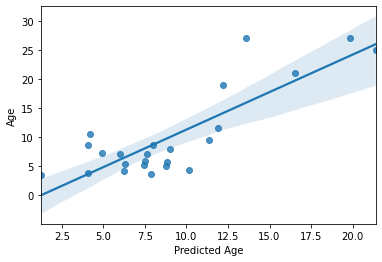

In [29]:
# print results
print('CV accuracy (R2) = ', acc)
print('CV MAE           = ', mae)

sns.regplot(x=y_pred,y=y_val)
plt.xlabel('Predicted Age')
plt.show()

Not perfect, but as predicting with unseen data goes, not too bad! Especially with a training sample of "only" 69 subjects. But we can do better in terms of estimating the accuracy of our model's performance!

For example, we can "increase" the size of our training set by using 10-fold cross-validation (CV) instead. 

## 6. Using *k*-fold CV to accurately assess model performance

<p align="center">
<img src="Imgs/KCV1.png" alt="terms" width="900"/>
</p>


In [30]:
from sklearn.model_selection import cross_val_predict, cross_val_score

# estimate CV scores
n_folds = 5
acc = cross_val_score(l_svr, X_train, y_train, cv=n_folds)
mae = cross_val_score(l_svr, X_train, y_train, cv=n_folds, scoring='neg_mean_absolute_error')
print(f"average ({n_folds}-fold) CV accuracy (R2) = %0.2f and standard deviation of %0.2f" % (acc.mean(), acc.std()))
print(f"average ({n_folds}-fold) CV MAE           = %0.2f and standard deviation of %0.2f" % (mae.mean(), mae.std()))

average (5-fold) CV accuracy (R2) = 0.54 and standard deviation of 0.10
average (5-fold) CV MAE           = -3.41 and standard deviation of 0.65


We can also look at the accuracy of the predictions for each fold of the cross-validation:

In [31]:
for i in range(n_folds):
    print('Fold {} -- Acc = {}, MAE = {}'.format(i, acc[i], mae[i]))

Fold 0 -- Acc = 0.3612087985222382, MAE = -3.110867088436961
Fold 1 -- Acc = 0.5996913995311426, MAE = -3.4332942648557925
Fold 2 -- Acc = 0.6412397813621165, MAE = -4.531290062834754
Fold 3 -- Acc = 0.6114723141980649, MAE = -3.450757876035308
Fold 4 -- Acc = 0.49088837264796414, MAE = -2.5410488520496455


Or we can also look at the overall accuracy of the model. In this case the data is split according to the CV parameter. Each sample belongs to exactly one validation set, and its prediction is computed with the model fitted on the corresponding training set.

Overall CV R2: 0.6147743044415694
Overall CV MAE: 3.422431161418837


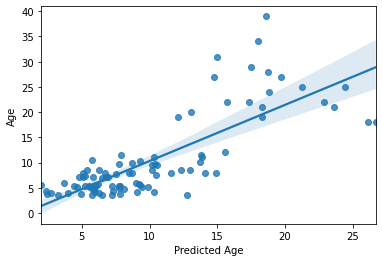

In [32]:
from sklearn.metrics import r2_score

y_pred = cross_val_predict(l_svr, X_train, y_train, cv=n_folds) # here we use our original training set
overall_acc = r2_score(y_train, y_pred)
overall_mae = mean_absolute_error(y_train,y_pred)

print('Overall CV R2:', overall_acc)
print('Overall CV MAE:', overall_mae)

sns.regplot(x=y_pred, y=y_train)
plt.xlabel('Predicted Age')
plt.show()

## 7. Tweak your model: *k*-fold CV for model selection

It's very important to learn when and where its appropriate to "tweak" your model.

Since we have done all of the previous analysis in our training data, it's fine to try out different models. But we **absolutely cannot** "test" it on our left out data. If we do, we are in great danger of overfitting.

It is not uncommon to try other models, or tweak hyperparameters. In this case, due to our relatively small sample size, we are probably not powered sufficiently to do so, and we would once again risk overfitting. However, for the sake of demonstration, we will do some tweaking. 

<p align="center">
<img src="Imgs/KCV2.png" alt="terms" width="400"/>
</p>



In [33]:
from sklearn.svm import SVR

# define models and set hyperparameters
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_rbf = SVR(kernel='rbf', C=100, gamma='auto') #0.1, epsilon=.1)
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=2) #, epsilon=.1, coef0=1)

models = {'svr_lin':svr_lin, 'svr_rbf':svr_rbf, 'svr_poly':svr_poly}

# perform k-fold CV with each model and evaluate performance
n_folds = 5
for name, model in models.items():
    print(f'\nPerformance for the {name.upper()} model:')
    acc = cross_val_score(model, X_train, y_train, cv=n_folds)
    mae = cross_val_score(model, X_train, y_train, cv=n_folds, scoring='neg_mean_absolute_error')
    print(f" average ({n_folds}-fold) CV accuracy (R2) = %0.2f with a standard deviation of %0.2f" % (acc.mean(), acc.std()))
    print(f" average ({n_folds}-fold) CV MAE           = %0.2f with a standard deviation of %0.2f" % (mae.mean(), mae.std()))
    


Performance for the SVR_LIN model:
 average (5-fold) CV accuracy (R2) = 0.54 with a standard deviation of 0.10
 average (5-fold) CV MAE           = -3.41 with a standard deviation of 0.65

Performance for the SVR_RBF model:
 average (5-fold) CV accuracy (R2) = 0.50 with a standard deviation of 0.07
 average (5-fold) CV MAE           = -3.47 with a standard deviation of 0.95

Performance for the SVR_POLY model:
 average (5-fold) CV accuracy (R2) = -0.14 with a standard deviation of 0.19
 average (5-fold) CV MAE           = -5.29 with a standard deviation of 1.67


Thanks to our k-fold CV analyses, we can identify the *best* candidate model. Note however that the SVR model possesses a number of *hyperparameters* that could be tuned to potentially improve our predictions. The type of kernel is a hyperparameter itself. Let's try this! 

## 8. Tweak your model: *k*-fold CV + Grid Search for hyperparameter tuning

To tune our model hyperparameters we can combine grid searh and cross validation!

<p align="center">
<img src="Imgs/KCV3.png" alt="terms" width="400"/>
</p>

SVR model documentation: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [34]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# let's create our grid search 
tunning_params = [{'kernel': ['poly', 'linear', 'rbf'], 'gamma': [1e-3, 1e-4, 'scale', 'auto'],
                   'C': [1, 10, 100, 1000], 'degree':[2,3,4,5], 'epsilon':[.1], 'coef0':[1]}]

print("Tuning hyper-parameters ... ")
n_folds = 5
clf = GridSearchCV(estimator=SVR(), param_grid=tunning_params, cv=n_folds)#, scoring='neg_mean_absolute_error')
clf.fit(X_train, y_train)

print("\nGrid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
print(f"\nBest score (R2): {clf.best_score_}")
# print(f"\nBest score (MAE): {clf.best_score_}")
print("Best parameters set found on development set:")
opt_hyperparams = clf.best_params_
print(opt_hyperparams)

Tuning hyper-parameters ... 

Grid scores on development set:
-0.145 (+/-0.387) for {'C': 1, 'coef0': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.541 (+/-0.206) for {'C': 1, 'coef0': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
-0.150 (+/-0.387) for {'C': 1, 'coef0': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
-0.194 (+/-0.398) for {'C': 1, 'coef0': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
0.541 (+/-0.206) for {'C': 1, 'coef0': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
-0.194 (+/-0.398) for {'C': 1, 'coef0': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.351 (+/-0.239) for {'C': 1, 'coef0': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.541 (+/-0.206) for {'C': 1, 'coef0': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
0.032 (+/-0.370) for {'C': 1, 'coef0': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 'sc

Thanks to our combined *k*-fold CV + Grid Search analysis, we have found the *best* model and the *best* set of model hyperparameters that maximize our (cross-validated) accuracy score, now what? 

## 9.  Ensemble methods and the *bias-variance* trade-off 

Now that we have selected the model and its hyper-parameters, we can now use ensemble methods, such as **bagging** and **boosting**, to improve the bias-variance trade-off of our model.  

In general, ensemble methods provide a way to reduce overfitting. **Bagging** improves the trade-off between bias and variance by slightly increasing the bias term, but allowing for a larger reduction of the variance term. Thefore, **bagging** methods are better suited for **strong and complex** models in which the variance is high.

On the other hand, **Boosting** improves the trade-off between bias and variance by slightly increasing the variance term, but allowing for a larger reduction of the bias term. Hence, **boosting** methods usually work best with **weak and simple** models in which the bias is high. 

These slight changes in the bias and/or the variance term *generally* result in a lower overall error and thus a better performance. 

<p align="center">
<img src="Imgs/ensemble.png" alt="terms" width="700"/>
</p>

In [35]:
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score

estimators = [("SVR", SVR(**opt_hyperparams)),
              ("Bagging(SVR)", BaggingRegressor(SVR(**opt_hyperparams))),
              ("Boosting(SVR)", AdaBoostRegressor(SVR(**opt_hyperparams)))
             ]

# Loop over estimators to compare
n_folds = 5
for n, (name, estimator) in enumerate(estimators):
    print(f'\nPerformance for the {name.upper()} model:')
    acc = cross_val_score(estimator, X_train, y_train, cv=n_folds)
    mae = cross_val_score(estimator, X_train, y_train, cv=n_folds, scoring='neg_mean_absolute_error')
    print(f" average ({n_folds}-fold) CV accuracy (R2) = %0.2f with a standard deviation of %0.2f" % (acc.mean(), acc.std()))
    print(f" average ({n_folds}-fold) CV MAE           = %0.2f with a standard deviation of %0.2f" % (mae.mean(), mae.std()))



Performance for the SVR model:
 average (5-fold) CV accuracy (R2) = 0.58 with a standard deviation of 0.06
 average (5-fold) CV MAE           = -3.27 with a standard deviation of 0.71

Performance for the BAGGING(SVR) model:
 average (5-fold) CV accuracy (R2) = 0.54 with a standard deviation of 0.04
 average (5-fold) CV MAE           = -3.32 with a standard deviation of 0.85

Performance for the BOOSTING(SVR) model:
 average (5-fold) CV accuracy (R2) = 0.55 with a standard deviation of 0.08
 average (5-fold) CV MAE           = -3.43 with a standard deviation of 0.79


### Bias-variance trade-off

In [36]:
n_repeat = 4
n_val = 13

age_class2 = pheno.loc[y_train.index,'AgeGroup']
X_train2, X_val, y_train2, y_val = train_test_split(
                                                    X_train, 
                                                    y_train, 
                                                    test_size = n_val,  
                                                    shuffle = True, 
                                                    stratify = age_class2,
                                                    )

X_train2 = np.split(X_train2, n_repeat)
y_train2 = np.split(y_train2, n_repeat)

In [37]:
estimators = [("SVR", SVR(**opt_hyperparams)),
              ("Bagging(SVR)", BaggingRegressor(SVR(**opt_hyperparams))),
              ("Boosting(SVR)", AdaBoostRegressor(SVR(**opt_hyperparams)))
             ]

n_estimators = len(estimators)

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    
    # Compute predictions
    y_predict = np.zeros((n_val, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train2[i], y_train2[i])
        y_predict[:, i] = estimator.predict(X_val)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_val)

    for i in range(n_repeat):
        y_error += (y_val - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)
    y_bias = (y_val - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)
    
    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var)".format(name,
                                    np.mean(y_error),
                                    np.mean(y_bias),
                                    np.mean(y_var),))


SVR: 17.3949 (error) = 68.5114 (bias^2)  + 1.0683 (var)
Bagging(SVR): 18.7761 (error) = 73.7076 (bias^2)  + 1.3968 (var)
Boosting(SVR): 14.6135 (error) = 56.4739 (bias^2)  + 1.9800 (var)


Although neither ensemble method yields better performance compared to the single estimator, notice how **boosting** contributes to reduce the bias of the model, whereas **bagging** contributes to reduce its variance!!! 

Which method is then the best? It really depends on the application. Some applications require a higher accuracy (low bias), whereas other prefer to sacrifice a bit of accuracy while guaranteeing a higher precision (low variance). There is always a trade-off!!!

## 10.  Model deployment

Ok, so now that we have found the optimal model and its hyperparameters its time to release a working version of the model for "production". This process implies at least two things:

* **Report model performance** - (using the unseen data!)
* **Prepare model for production**  

Because we are not planning to make further changes in the model, we can now use our entire data set to report our model's performance, and to train our final model! 

### 1. Reporting model performance

Now that we have decided about our model and its hyperparameters, we are going to use our unseen test data set to report the performance of our model. 

In [38]:
# cross-validation
estimator = SVR(**opt_hyperparams)
estimator.fit(X_train, y_train) 
y_pred = estimator.predict(X_test) 

acc = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)

print('accuracy (R2) = ', acc)
print('MAE           = ', mae)

R2: 0.7064356257714892
MAE: 2.6894125495170766


***Wow!!!*** Congratulations. You just trained a machine learning model that used real rs-fmri data to predict the age of real humans. 

The proper thing to do, however, would be to repeat the train-validation split multiple times. This will ensure the results are not specific to this validation set, and will give you some confidence intervals around your results.

In [39]:
# kth-fold cross-validation
estimator = SVR(**opt_hyperparams)
n_folds = 5

# acc = cross_val_score(estimator, X_train, y_train, cv=n_folds)
# mae = cross_val_score(estimator, X_train, y_train, cv=n_folds, scoring='neg_mean_absolute_error')

acc = cross_val_score(estimator, X_features, y_age, cv=n_folds)
mae = cross_val_score(estimator, X_features, y_age, cv=n_folds, scoring='neg_mean_absolute_error')

print("Model: SVR")
print(f"Model hyperparameters:{opt_hyperparams}")

print(f"\nModel performance:")
print(f" average ({n_folds}-fold) CV accuracy (R2) = %0.2f with a standard deviation of %0.2f" % (acc.mean(), acc.std()))
print(f" average ({n_folds}-fold) CV MAE           = %0.2f with a standard deviation of %0.2f" % (mae.mean(), mae.std()))

print(f"\nModel performance per fold:")
for i in range(n_folds):
    print(' Fold {} -- Acc (R2) = {}, MAE = {}'.format(i, acc[i], mae[i]))

Model: SVR
Model hyperparameters:{'C': 100, 'coef0': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}

Model performance:
 average (5-fold) CV accuracy (R2) = -36.26 with a standard deviation of 40.03
 average (5-fold) CV MAE           = -4.97 with a standard deviation of 4.87

Model performance per fold:
 Fold 0 -- Acc (R2) = -83.10237675687958, MAE = -3.3055710190178447
 Fold 1 -- Acc (R2) = -87.19833039605729, MAE = -2.086313149366476
 Fold 2 -- Acc (R2) = -2.900296750516725, MAE = -1.8770930883174557
 Fold 3 -- Acc (R2) = -0.002754640945798137, MAE = -2.941364161082747
 Fold 4 -- Acc (R2) = -8.08330271653628, MAE = -14.644675761507518


So, it seems like something in this data does seem to be systematically related to age ... but what? 

### 2. Model deployment

Assuming that our model's performance was good, we could now use either the entire training set, if the application context requires a very conservative model, or the entire data set, if the application context is not too conservative, to train the final model for "production". 

In [40]:
# conservative scenario
estimator = SVR(**opt_hyperparams)
estimator.fit(X_train, y_train)

# nonconservative scenario
estimator = SVR(**opt_hyperparams)
estimator.fit(X_features, y_age) 

SVR(C=100, coef0=1, degree=2, gamma=0.001)

## Final remarks

1. The MORE DATA the better!
2. BUT ... hopefully your data is as heterogeneous as possible to avoid BIASES in the model! 
3. ALWAYS get familiar with your data first --> use visualization tools! 
4. Do NOT touch your test data set until the very END!
5. Always go from simple to complex, especially if you do not have a lot observations!